In [1]:
# importing useful libraries
%matplotlib inline

import numpy as np
import pandas as pd
from heapq import heapify, heappush, heappop
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(0)

# Question 1

In [2]:
# reading data into a dataframe
df = pd.read_csv('classification.csv')

In [3]:
# analyzing data
df.describe()

,age,interest,success
count,297.000000,297.000000,297.000000
mean,23.709718,46.986527,0.569024
std,8.864000,21.956447,0.496049
min,2.347560,-0.852800,0.000000
25%,17.002148,28.689067,0.000000
50%,23.283644,45.695926,1.000000
75%,30.661149,65.171876,1.000000
max,45.773729,97.175508,1.000000


In [4]:
# getting shape of dataset
df.shape

(297, 3)

In [5]:
# getting positive and negative instances
df_pos = df[df['success'] == 1]
df_neg = df[df['success'] == 0]

<Figure size 432x288 with 0 Axes>

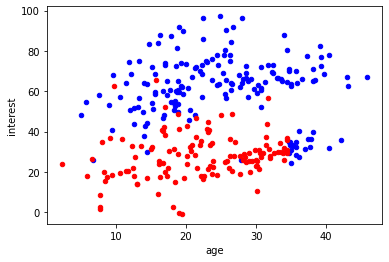

In [6]:
# plotting data
def plot_data():
    ax = df_pos.plot(kind='scatter', x='age', y='interest', color='blue')
    df_neg.plot(kind='scatter', x='age', y='interest', color='red', ax=ax)

def plot_data_3d(ax):
    ax.scatter(df_pos['age'], df_pos['interest'], df_pos['success'], color = 'blue')
    ax.scatter(df_neg['age'], df_neg['interest'], df_neg['success'], color = 'red')

plt.figure()
plot_data()

In [7]:
# obtain label and feature matrix

# add bias term
X = df[['age', 'interest']]
X['bias'] = 1

# get numpy arrays
X = X.to_numpy()
Y = df[['success']].to_numpy()

In [8]:
# get misclassified

def misclassified(y, Y):
    return np.sum(np.abs((1*(y > 0.5))-Y))/len(Y)

Misclassified: 0.12457912457912458


<Figure size 432x288 with 0 Axes>

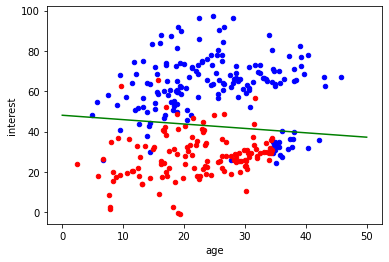

In [9]:
# least squares method

def ls_fit(X, Y):
    # we use normal equation for least squares method
    w = (np.linalg.pinv(X.T @ X)) @ (X.T @ Y)
    return w

def plot_line(w):
    # if f(x) = w1.x1 + w2.x2 + w3
    # f(x) = 0.5 should be the line dividing
    # the dataset into two classes
    
    # age value is less than 50 for
    # every row
    x = np.linspace(0, 50, 1000)
    y = (0.5 - w[2] - w[0] * x) / w[1]
    plt.plot(x, y, 'green')

# obtain weights
w = ls_fit(X, Y)

# plot
plt.figure()
plot_data()
plot_line(w)

# misclassified
print(f'Misclassified: {misclassified(X@w, Y)}')

In [10]:
# logistic regression using stochastic gradient descent

step_size = 1e-3
num_iterations = 2000
WATCH_CONVERGENCE = False

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def h(x, w):
    # computes what is passed to sigmoid
    ans = x @ w
    return ans

def lr_fit(X, Y, step_size = 1e-3, num_iterations = 2000, WATCH_CONVERGENCE = False):
    # initializing weights in [-0.1, 0.1]
    w = (np.random.rand(X.shape[1]) - 0.5) / 5
    
    # gradient descent
    for _ in range(num_iterations):
        for i in range(X.shape[0]):
            w = w + step_size * (Y[i] - sigmoid(h(X[i], w))) * X[i]
        
        if (_% 50 == 0 and WATCH_CONVERGENCE):
            print(w)
    
    return w

# obtain weights
w = lr_fit(X, Y, step_size, num_iterations, WATCH_CONVERGENCE)

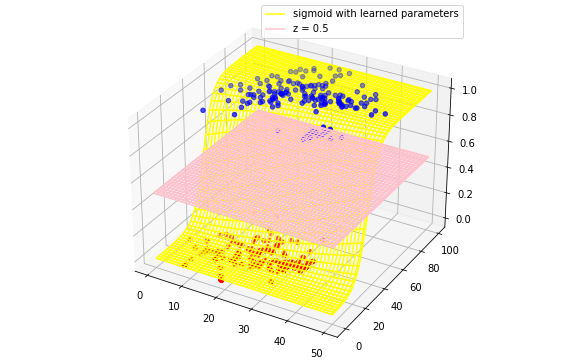

In [11]:
%matplotlib widget

# 3d plot of learnt sigmoid

def sigmoid_from_coordinates(x, y):
    return sigmoid(h(np.array([x, y, 1], dtype=object), w))

def plane(x, y):
    return (x+y)*0 + 0.5

def plot_sigmoid(ax, w):
    x = np.outer(np.linspace(0, 50, 100), np.ones(100))
    y = np.outer(np.linspace(0, 100, 100), np.ones(100)).T
    
    z = sigmoid_from_coordinates(x, y)
    ax.plot_wireframe(x, y, z, color = 'yellow', label = 'sigmoid with learned parameters')
    
    z = plane(x, y)
    ax.plot_wireframe(x, y, z, color = 'pink', label = 'z = 0.5')
    
    ax.legend()

# plot
fig = plt.figure(figsize=(8, 5))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plot_data_3d(ax)
plot_sigmoid(ax, w)

Misclassified: 0.12457912457912458


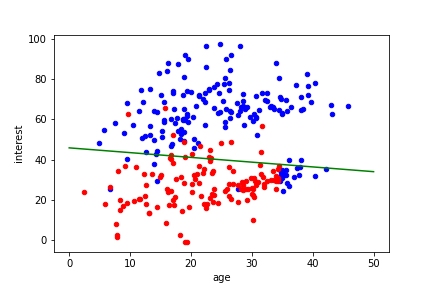

In [12]:
# plotting decision boundary for learnt sigmoid

def plot_sigmoid_boundary(w):
    # if h(x) = w1.x1 + w2.x2 + w3
    # h(x) = 0 should be the line dividing
    # the dataset into two classes
    # because sigmoid(h(x)) = 0.5 only for h(x) = 0
    
    # age value is less than 50 for
    # every row
    x = np.linspace(0, 50, 1000)
    y = (- w[2] - w[0] * x) / w[1]
    plt.plot(x, y, 'green')

# misclassified
print(f'Misclassified: {misclassified(sigmoid(h(X, w).reshape(len(Y), -1)), Y)}')

plot_data()
plot_sigmoid_boundary(w)

In [13]:
# splitting dataset into two classes

D1 = df[df['success'] == 1]
D2 = df[df['success'] == 0]

# add bias term
X1 = D1[['age', 'interest']]
X1['bias'] = 1

X2 = D2[['age', 'interest']]
X2['bias'] = 1

# get numpy arrays
X1 = X1.to_numpy()
X2 = X2.to_numpy()

In [14]:
# LDA

### all the vectors have to be two dimensional

def calc_B(m1, m2):
    diff = m1 - m2
    return diff.T@diff

def calc_S(X, m):
    diff = (X - m)
    return diff.T@diff

def fit(X1, X2):
    m1 = np.mean(X1, axis=0, keepdims=True)
    m2 = np.mean(X2, axis=0, keepdims=True)
    
    B = calc_B(m1, m2)
    S1 = calc_S(X1, m1)
    S2 = calc_S(X2, m2)
    S = S1 + S2
    
    return np.linalg.pinv(S)@((m2-m1).T)

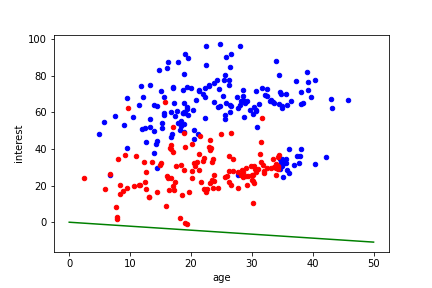

In [15]:
# fit and plot linear discriminant boundary

def plot_line(w):
    # if f(x) = w1.x1 + w2.x2 + w3
    # f(x) = 0 should be the line
    # perpendicular to which points 
    # if projected will have maximum 
    # separation where separation is 
    # defined as the objective function
    # for LDA
    
    x = np.linspace(0, 50, 1000)
    if (w[1] == 0):
        y = np.linspace(0, 0, 1000)
    else:
        y = (0 - w[2] - w[0] * x) / w[1]
    plt.plot(x, y, 'green')
    
weights = fit(X1, X2)
    
plot_data()
plot_line(weights)

In [16]:
# higher dimensions - 2
df_2 = df[['age', 'interest']]

df_2['age^2'] = df_2['age'] ** 2
df_2['interest^2'] = df_2['interest'] ** 2

df_2['age*interest'] = df_2['age'] * df_2['interest']

df_2['bias'] = 1

In [17]:
# normalize to avoid overflows
factors = df_2.max().to_numpy()
df_2_normalized = df_2 / df_2.max()

In [18]:
# design matrix for two dimensions
X_normalized = df_2_normalized.to_numpy()
X = df_2.to_numpy()

In [19]:
# regression
w_normalized = lr_fit(X_normalized, Y, 1, 4000, False)

In [20]:
# scale down w to accomodate initial normalization
w = w_normalized / factors

Misclassified: 0.08080808080808081


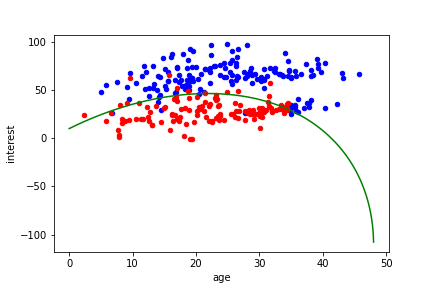

In [21]:
# plotting decision boundary for learnt sigmoid

def plot_sigmoid2_boundary(w):
    # if h(x) = w1.x1 + w2.x2 + w3
    # h(x) = 0 should be the line dividing
    # the dataset into two classes
    # because sigmoid(h(x)) = 0.5 only for h(x) = 0
    
    # age value is less than 48 for
    # every row
    x = np.linspace(0, 48, 1000)
    D = (w[1] + w[4]*x)**2 -4*w[3]*(w[0]*x + w[2]*(x**2) + w[5])
    y1 = (-w[1] - w[4] * x + (D**0.5)) / (2*w[3])
    
    plt.plot(x, y1, 'green')


plot_data()
plot_sigmoid2_boundary(w)

# misclassifications
print(f'Misclassified: {misclassified(sigmoid((X@w).reshape(len(Y), -1)), Y)}')

In [22]:
# higher dimensions - 3
df_3 = df_2

df_3['age^3'] = df_2['age'] ** 3
df_3['interest^3'] = df_2['interest'] ** 3

df_3['age^2*interest'] = df_3['age^2'] * df_3['interest']
df_3['age*interest^2'] = df_3['age'] * df_3['interest^2']

In [23]:
# normalize to avoid overflows
factors = df_3.max().to_numpy()
df_3_normalized = df_3 / df_3.max()

In [24]:
# design matrix for three dimensions
X_normalized = df_3_normalized.to_numpy()
X = df_3.to_numpy()

In [25]:
# regression
w_normalized = lr_fit(X_normalized, Y, 1, 4000, False)

In [26]:
# scale down w to accomodate initial normalization
w = w_normalized / factors

In [27]:
# misclassifications
print(f'Misclassified: {misclassified(sigmoid((X@w).reshape(len(Y), -1)), Y)}')

Misclassified: 0.06397306397306397


In [28]:
# higher dimensions - 4
df_4 = df_3

df_4['age^4'] = df_3['age'] ** 4
df_4['interest^4'] = df_3['interest'] ** 4

df_4['age^3*interest'] = df_3['age^3'] * df_3['interest']
df_4['age*interest^3'] = df_3['age'] * df_3['interest^3']

df_4['age^2*interest^2'] = df_3['age^2'] * df_3['interest^2']

In [29]:
# normalize to avoid overflows
factors = df_4.max().to_numpy()
df_4_normalized = df_4 / df_4.max()

In [30]:
# design matrix for two dimensions
X_normalized = df_4_normalized.to_numpy()
X = df_4.to_numpy()

In [31]:
# regression
w_normalized = lr_fit(X_normalized, Y, 1, 4000, False)

In [32]:
# scale down w to accomodate initial normalization
w = w_normalized / factors

In [33]:
# misclassifications
print(f'Misclassified: {misclassified(sigmoid((X@w).reshape(len(Y), -1)), Y)}')

Misclassified: 0.06397306397306397


In [34]:
%reset -f

# Question 2

In [35]:
# importing useful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from heapq import heapify, heappush, heappop

np.random.seed(0)

In [36]:
# reading data into dataframe
df = pd.read_csv('adult.data', header=None, sep=', ', engine='python')

# giving column labels
headings = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
            'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
            'income']
df.columns = headings

In [37]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [38]:
class Criteria:
    def __init__(self, is_discrete, value, is_greater):
        # is_greater is defined only for continuous else None
        self.__is_discrete = is_discrete
        self.__value = value
        self.__is_greater = is_greater
    
    def __call__(self, x):
        if (self.__is_discrete):
            return x == self.__value
        elif (self.__is_greater):
            return x > self.__value
        else:
            return x <= self.__value

    def __repr__(self):
        if (self.__is_discrete):
            return f'x={self.__value}'
        elif (self.__is_greater):
            return f'x>{self.__value}'
        else:
            return f'x<={self.__value}'

In [39]:
class Node:
    def __init__(self, df, level, criteria, label):
        self.df = df
        self.level = level
        self.children = []
        self.criteria = criteria # criteria (type Criteria) which tells if given value of attribute is satisfied
        self.attribute = None # attribute on which this node is further divided, none implies leaf node
        
        l = list(df[label]) # list of labels in dataframe of current_node
        try:
            self.verdict = max(l, key = l.count) # most likely label
        except:
            self.verdict = None # in case this node cannot be further split
        
    def get_criteria(self, dtree):
        # dtree is the reference to the tree of which this node is a part of
        
        # check if no need to split
        if (len(set(self.df[dtree.label])) == 1): return None, None, None, True
        
        
        best_attribute = None
        best_gain = float('-inf')
        best_split = None
        # iterate over each attribute to find information gain
        
        for attr in self.df:
            if (attr == dtree.label or len(set(self.df[attr])) == 1):
                continue
            if (dtree.attribute_types[attr] == 'discrete'):
                gain = self.__discrete_gain(attr, dtree.label)
                if (gain > best_gain):
                    best_gain = gain
                    best_attribute = attr
                    best_split = None
            else:
                gain, split = self.__continuous_gain(attr, dtree.label)
                if (gain > best_gain):
                    best_gain = gain
                    best_attribute = attr
                    best_split = split
        
        return best_attribute, best_split, best_gain, False
    
    def __discrete_gain(self, attribute, label):
        
        gain = Node.entropy(self.df, label)
        
        for val in set(self.df[attribute]):
            df_val = self.df[self.df[attribute] == val]
            gain -= (Node.entropy(df_val, label) * (df_val.shape[0] / self.df.shape[0]))
            
        return gain
    
    def __continuous_gain(self, attribute, label):
        n = self.df.shape[0]
        df_as_list = [(self.df[attribute][i], self.df[label][i]) for i in self.df.index]
        df_as_list.sort()
        df_less, df_more = {}, {}
        num_less, num_more = 0, n
        
        for a, l in df_as_list:
            try:
                df_more[l] += 1
            except:
                df_more[l] = 1
                
        full_entropy = Node.entropy_from_dict(df_more, n)
        
        best_split_value = None
        best_gain_value = float('-inf')
        
        for i in range(n-1):
            a, l = df_as_list[i]
            
            df_more[l] -= 1
            num_more -= 1
            if (df_more[l] == 0):
                del df_more[l]
            
            try:
                df_less[l] += 1
            except:
                df_less[l] = 1
            num_less += 1

            if (df_as_list[i][0] == df_as_list[i+1][0]):
                continue
            
            gain = full_entropy
            
            # less than or equal to
            gain -= Node.entropy_from_dict(df_less, num_less) * (num_less / n)
            
            # greater than
            gain -= Node.entropy_from_dict(df_more, num_more) * (num_more / n)
            
            split_value = (df_as_list[i][0] + df_as_list[i+1][0]) / 2
            
            if (gain > best_gain_value):
                best_split_value = split_value
                best_gain_value = gain
            
        return best_gain_value, best_split_value

    @staticmethod
    def entropy_from_dict(d: dict, s: int):
        # s is the sum of values from key-value pair of d
        e = 0
        for val in d:
            i = d[val]
            if (i == 0): continue
            e -= (i/s)*np.log2(i/s)
        return e

    @staticmethod
    def entropy(df, label):
        '''
        l is the list of count for
        different keys
        '''
        s = df.shape[0]
        e = 0
        for val in set(df[label]):
            i = (list(df[label] == val)).count(True)
            if (i == 0): continue
            e -= (i/s)*np.log2(i/s)
        return e
    
    def print_node(self, label):
        print('\t'*self.level, self.criteria, sep='')
        if (self.children):
            print('\t'*self.level, f'({self.attribute})', sep='', end=' ')
        else:
            l = list(self.df[label]) # list of labels in dataframe of node
            x = max(l, key = l.count)
            print('\t'*self.level, f'{x} {l.count(x)/len(l)}', sep = '', end='')
        print()
        for child in self.children:
            child.print_node(label)
    
    def num_mismatches(self, label):
        poss = set(self.df[label])
        ans = float('inf')
        for val in poss:
            ans = min(ans, self.df[self.df[label] == val].shape[0])
        return ans

In [40]:
class DecisionTree:
    def __init__(self, df, label, attribute_types, num_levels = float('inf')):
        self.label = label # header for the label attribute
        self.attribute_types = attribute_types # dictionary telling type (discrete/continuous) for each attribute
        
        self.root = Node(df, 0, Criteria(lambda: True, None, None), label)
        self.num_nodes = 1
        self.height = num_levels
        
        split_attribute, split_value, split_gain, is_leaf = self.root.get_criteria(self)
        
        # leaves is a priority queue storing the leaf nodes with atleast 1 mismatch
        self.leaves = [(-split_gain, split_attribute, split_value, is_leaf, self.num_nodes, self.root)]
        heapify(self.leaves)

        self.has_warned = False
        
    def build_tree(self):
        if (not self.leaves):
            if (not self.has_warned):
                print('No more splits required')
                self.has_warned = True
            return
        split_gain, split_attribute, split_value, is_leaf, _, node = heappop(self.leaves)
        split_gain *= -1
        self.__build_tree(split_gain, split_attribute, split_value, is_leaf, node)
    
    def test_error(self, df):
        test_features = df.to_dict(orient='records')
        
        mismatches = 0
        
        for features in test_features:
            predicted_value = self.predict(features)
            mismatches += (predicted_value != features[self.label]) * 1
        
        return mismatches/df.shape[0]
        
    def predict(self, features):
        current_node = self.root
        
        while (current_node.children):
            valid = False
            for child in current_node.children:
                if (child.criteria(features[current_node.attribute])):
                    current_node = child
                    valid = True
                    break
            if (valid == False):
                # no child matching this criteria
                # so we stop at this node
                break

        return current_node.verdict
    
    def train_error(self):
        mismatches = 0
        for x in self.leaves:
            mismatches += x[5].num_mismatches(self.label)
        return mismatches/self.root.df.shape[0]
        
    def __build_tree(self, split_gain, split_attribute, split_value, is_leaf, node):
        # returns the list of children for given node
        
        if (node.level == self.height): return # leaf node
        
        if (is_leaf): return # no need to split further
        
        node.attribute = split_attribute
        
        if (self.attribute_types[split_attribute] == 'discrete'):
            df = node.df
            node.children = [Node(
                                df[df[split_attribute] == val][df.columns.drop(split_attribute)],
                                node.level + 1,
                                Criteria(True, val, None),
                                self.label
                                 ) 
                             for val in set(node.df[split_attribute])
                            ]
        
        else:
            df = node.df
            node.children = [Node(
                                df[df[split_attribute] <= split_value], 
                                node.level + 1, 
                                Criteria(False, split_value, False),
                                self.label
                                 ),
                             Node(
                                 df[df[split_attribute] > split_value], 
                                 node.level + 1, 
                                 Criteria(False, split_value, True),
                                 self.label
                                  )
                            ]
            
        for child in node.children:
            split_attribute, split_value, split_gain, is_leaf = child.get_criteria(self)
            # is_leaf is true if this node cannot be further split
            # split_value is returned only if split_attribute is continuous otherwise None
            
            if (is_leaf):
                continue
            
            self.num_nodes += 1
                
            heappush(self.leaves, (-split_gain, split_attribute, split_value, is_leaf, self.num_nodes, child))
            
    def print_tree(self):
        print('root')
        if (self.root.children):
            print(f'({self.root.attribute})')
        for child in self.root.children:
            child.print_node(self.label)

In [41]:
# splitting dataset into training and testing set

mask = np.random.rand(len(df)) < 0.8

df_train = df[mask]
df_test = df[~mask]

In [42]:
# dataset

attribute_types = {
    "age": "continuous",
    "workclass": "discrete",
    "fnlwgt": "continuous",
    "education": "discrete",
    "education-num": "continuous",
    "marital-status": "discrete",
    "occupation": "discrete",
    "relationship": "discrete",
    "race": "discrete",
    "sex": "discrete",
    "capital-gain": "continuous",
    "capital-loss": "continuous",
    "hours-per-week": "continuous",
    "native-country": "discrete"
}

# height can be set and passed into DecisionTree to limit height of the tree
# height = 5


dtree = DecisionTree(df_train,
                    "income",
                    attribute_types)

In [43]:
# training and testing

num_splits = 200

nodes = []
train_errors = []
test_errors = []

for i in range(num_splits):
    dtree.build_tree()
    
    nodes.append(dtree.num_nodes)
    train_errors.append(dtree.train_error())
    test_errors.append(dtree.test_error(df_test))

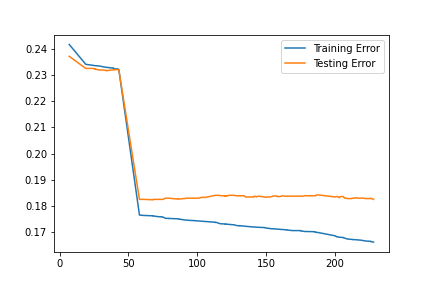

In [44]:
plt.figure()
plt.plot(nodes, train_errors, label='Training Error')
plt.plot(nodes, test_errors, label='Testing Error')
plt.legend()
plt.show()

In [45]:
dtree.print_tree()

root
(relationship)
	x=Wife
	(occupation) 
		x=Exec-managerial
		(education) 
			x=Prof-school
			>50K 1.0
			x=Assoc-acdm
			(age) 
				x<=36.5
				(age) 
					x<=26.0
					<=50K 1.0
					x>26.0
					(age) 
						x<=34.0
						(fnlwgt) 
							x<=329129.0
							>50K 1.0
							x>329129.0
							<=50K 1.0
						x>34.0
						<=50K 1.0
				x>36.5
				>50K 1.0
			x=Masters
			(workclass) 
				x=State-gov
				>50K 1.0
				x=Local-gov
				>50K 1.0
				x=Self-emp-not-inc
				>50K 1.0
				x=Self-emp-inc
				>50K 1.0
				x=Private
				(fnlwgt) 
					x<=225427.0
					(age) 
						x<=54.5
						(age) 
							x<=32.5
							(age) 
								x<=30.5
								>50K 1.0
								x>30.5
								<=50K 1.0
							x>32.5
							>50K 1.0
						x>54.5
						<=50K 1.0
					x>225427.0
					<=50K 1.0
			x=9th
			(age) 
				x<=51.5
				<=50K 1.0
				x>51.5
				>50K 1.0
			x=7th-8th
			<=50K 1.0
			x=Assoc-voc
			(age) 
				x<=32.5
				<=50K 1.0
				x>32.5
				>50K 1.0
			x=10th
			<=50K 1.0
			x=Bachelors
			(nat

		>50K 0.6816786079836233
		x=Doctorate
		>50K 0.8372093023255814
		x=11th
		(capital-gain) 
			x<=2869.0
			<=50K 0.9162995594713657
			x>2869.0
			(hours-per-week) 
				x<=27.5
				<=50K 1.0
				x>27.5
				>50K 1.0
		x=Some-college
		<=50K 0.5680775114737379
		x=Preschool
		<=50K 1.0
		x=HS-grad
		<=50K 0.6833137485311398
	x=Not-in-family
	<=50K 0.8969950665271341
	x=Other-relative
	<=50K 0.9596879063719116
	x=Unmarried
	<=50K 0.9364791288566243
	x=Own-child
	<=50K 0.9867256637168141


In [46]:
# number of splits corresponding to the minimum test error
optimal_splits = test_errors.index(min(test_errors)) + 1
print(f'optimal splits: {optimal_splits}')

optimal splits: 36


In [47]:
# create 10 datasets using bootstrap technique
# train 10 decision trees each on one of the datasets

N = 10

datasets = []

n = df_train.shape[0]

for i in range(N):
    randlist = pd.DataFrame(index=np.random.randint(n, size=n))
    datasets.append(df_train.merge(randlist, left_index=True, right_index=True, how='right'))
    datasets[i].reset_index(drop=True, inplace=True)

decision_trees = [DecisionTree(datasets[i], "income", attribute_types) for i in range(N)]

In [48]:
# training each of the 10 decision trees

for i in range(N):
    for _ in range(optimal_splits):
        decision_trees[i].build_tree()

In [49]:
# testing
test_features = df_test.to_dict(orient='records')
        
mismatches = 0

for features in test_features:
    predictions = [tree.predict(features) for tree in decision_trees]
    predicted_value = max(predictions, key=predictions.count)
    mismatches += (predicted_value != features['income'])

print(f'Mismatches: {mismatches/len(test_features)}')

Mismatches: 0.18307905686546463
